<a href="https://colab.research.google.com/github/FerminMendez/ModuleAI/blob/main/Statistic/AnalisisIndicadorActividadIndustrialQroipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introducción



##Sobre el trabajo
En este trabajo analizaremos el índice de actividad industrial en Querétaro desde el año 1983 hasta el 2023. Usando un modelo autoregresivo ARIMA-SARIMA harémos la predicción de este índice hasta el 2030.
## Sobre el modelo ARIMA-SARIMA
Autoregressive Integrated Moving Average Seasonal model (ARIMA/SARIMA)
Es un modelo de predicción que ha demostrado grandes resultados para predecir comportamientos historicos mensuales o cuatrimestrales en el ámbito ecónomico.

El modelo es se compone de dos partes AR y MA
*   AR: Explica la autocorrelación con sus valores pasados. Tambien conocida como memoria a largo plazo.
*   MA: Es la memoria a largo plazo donde solo nos importa el shock de ayer.







#0 Importar los datos


In [170]:
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns

In [171]:

drive.mount("/content/gdrive")
!pwd
%cd "/content/gdrive/MyDrive/DataSetIA/INEGI"
!ls


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/DataSetIA/INEGI
/content/gdrive/MyDrive/DataSetIA/INEGI
IMAI_2.csv  IndicadorActividadIndustrialQro.csv  Indicadores20231012091045.csv


In [172]:
data = pd.read_csv('IndicadorActividadIndustrialQro.csv')
data.head()

,Periodos,iaiqro
0,2003/01,65.234491
1,2003/02,64.750420
2,2003/03,61.444991
3,2003/04,64.953065
4,2003/05,59.522348


## Agregando más variables




Nos interesa no solo tener disponibles los valores originales, vamos a incluir algunos crecimientos porcentuales y el ln de los datos


In [173]:
data['ln']=np.log(data['iaiqro'])
data['diff_1']=data['ln']-data['ln'].shift(1)
data['diff_12']=data['ln']-data['ln'].shift(12)
serie_diff1=data['diff_1'].dropna()
serie_diff12=data['diff_12'].dropna()
df=data.copy()


## Descripción de nuestros datos

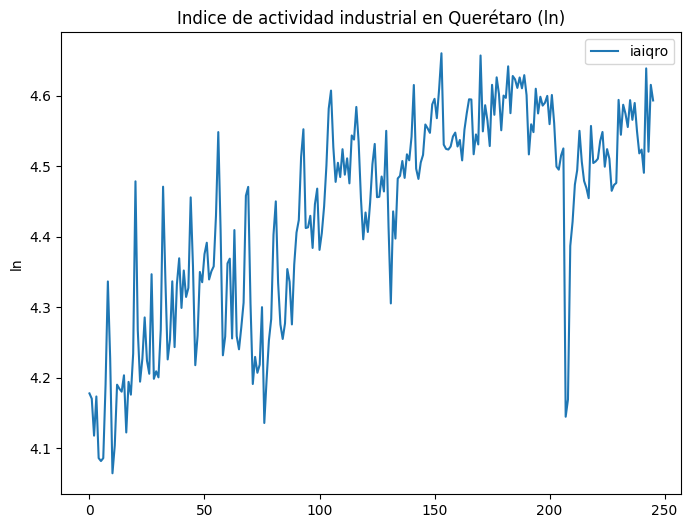

In [174]:
plt.figure(figsize=(8, 6))
sns.lineplot(x=df.index, y='ln', data=df, label='iaiqro')
plt.title("Indice de actividad industrial en Querétaro (ln)")
plt.show()

In [175]:
print(df.head(15))
print(df.tail(10))

   Periodos     iaiqro        ln    diff_1   diff_12
0   2003/01  65.234491  4.177988       NaN       NaN
1   2003/02  64.750420  4.170540 -0.007448       NaN
2   2003/03  61.444991  4.118142 -0.052398       NaN
3   2003/04  64.953065  4.173665  0.055523       NaN
4   2003/05  59.522348  4.086352 -0.087313       NaN
5   2003/06  59.273040  4.082155 -0.004197       NaN
6   2003/07  59.521204  4.086333  0.004178       NaN
7   2003/08  66.044043  4.190322  0.103989       NaN
8   2003/09  76.448073  4.336612  0.146290       NaN
9   2003/10  68.567827  4.227823 -0.108788       NaN
10  2003/11  58.255490  4.064838 -0.162985       NaN
11  2003/12  60.594364  4.104202  0.039364       NaN
12  2004/01  66.045678  4.190347  0.086145  0.012358
13  2004/02  65.668412  4.184618 -0.005729  0.014078
14  2004/03  65.394662  4.180441 -0.004177  0.062298
    Periodos      iaiqro        ln    diff_1   diff_12
236  2022/09   96.118097  4.565578 -0.027887  0.066409
237  2022/10   98.439963  4.589447  0.0238

In [176]:
df.describe()

,iaiqro,ln,diff_1,diff_12
count,246.000000,246.000000,245.000000,234.000000
mean,85.026453,4.432653,0.001694,0.021084
std,11.861260,0.146232,0.074281,0.085070
min,58.255490,4.064838,-0.380091,-0.429682
25%,76.178830,4.333083,-0.035028,-0.020141
50%,88.063453,4.478058,0.006976,0.025605
75%,94.463242,4.548211,0.041663,0.067974
max,105.621683,4.659864,0.244090,0.359408


Nuestro dataset contiene información mensual desde Enero del 2003 hasta Junio de 2023.
Podemos observar que es una serie que tiene tendencia a la alza.

# 3 Modelo ARIMA SARIMA

## Encontrando una serie estacionaria

Un requisito para trabajar con un modelo ARIMA SARIMA es que tenemos que trabajar con una serie estacionaria. La mejor manera de determinar con certeza es aplicar la prueba estadistica de Dickey-fuller donden plantea una que es una prueba estadistica con la siguiente hipóteisis:

*   H0: La serie S no es estacionaria
*   Ha: La serie S es estacionaria

Una vez aplicada una prueba obtener un p-value menor a 0.05 nos da pruebas estadisticas de que la serie S es estacionaria. En el caso que la serie original no es estacionaria se aplica primera o segunda diferencia para poder trabajar un modelo ARIMA-SARIMA




In [177]:
from statsmodels.tsa.stattools import adfuller


### Probando estacionalidad en la serie original

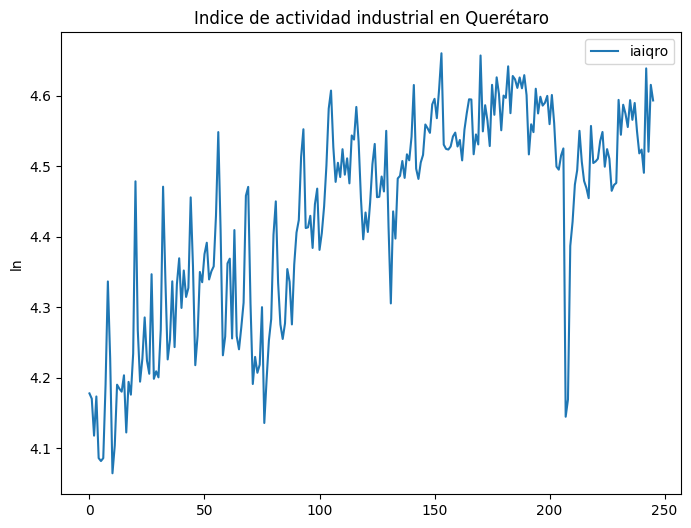

In [178]:
plt.figure(figsize=(8, 6))
sns.lineplot(x=df.index, y='ln', data=df, label='iaiqro')
plt.title("Indice de actividad industrial en Querétaro")
plt.show()

A simple vista podemos notar que NO es una serie estacionaria. A pesar de eso vamos a aplicar una prueba de Dickey-Fuller

In [179]:
adfuller(data['ln'])

(-2.0402700406367744,
 0.269199852269533,
 12,
 233,
 {'1%': -3.458731141928624,
  '5%': -2.8740258764297293,
  '10%': -2.5734243167124093},
 -677.3859088725994)

### Probando estacionalidad en la serie de crecimientos porcentuales mensuales





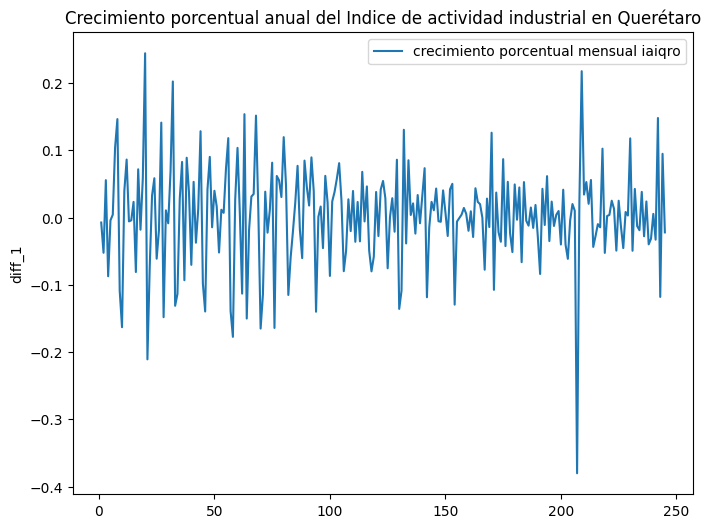

In [180]:
plt.figure(figsize=(8, 6))
sns.lineplot(x=df.index, y='diff_1', data=df, label='crecimiento porcentual mensual iaiqro')
plt.title("Crecimiento porcentual anual del Indice de actividad industrial en Querétaro")
plt.show()

In [181]:
adfuller(serie_diff1)

(-5.599507208127476,
 1.274284391498185e-06,
 11,
 233,
 {'1%': -3.458731141928624,
  '5%': -2.8740258764297293,
  '10%': -2.5734243167124093},
 -672.4921025082533)

### Probando estacionalidad en la serie de crecimientos porcentuales anuales

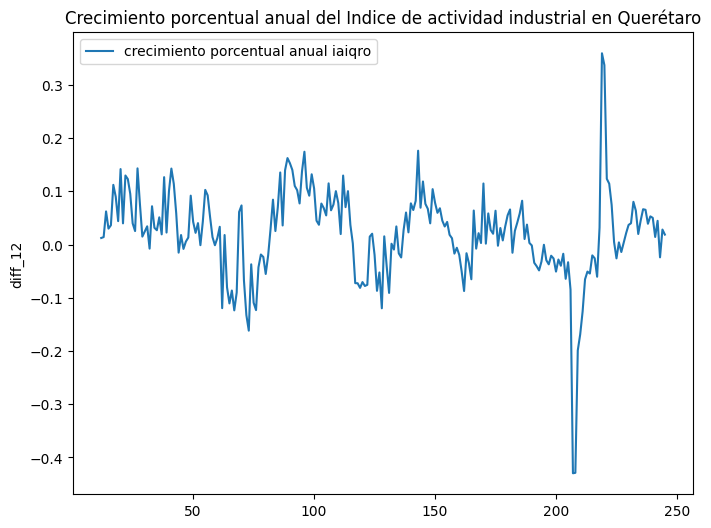

In [182]:
plt.figure(figsize=(8, 6))
sns.lineplot(x=df.index, y='diff_12', data=df, label='crecimiento porcentual anual iaiqro')
plt.title("Crecimiento porcentual anual del Indice de actividad industrial en Querétaro")
plt.show()

In [183]:
adfuller(serie_diff12)

(-3.399292659245505,
 0.010983008452611525,
 12,
 221,
 {'1%': -3.4602906385073884,
  '5%': -2.874708679520702,
  '10%': -2.573788599127782},
 -629.7831324971307)

## Midiendo autocorrelación y autocorrelación parcial (AC y PAC)

In [184]:
#Imports de stasts models
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


En este caso vamos a analizar el cambio porcentual anual, que como ya comprobamo, es una serie estacionaria.

### Autocorrelación AC



<class 'pandas.core.series.Series'>


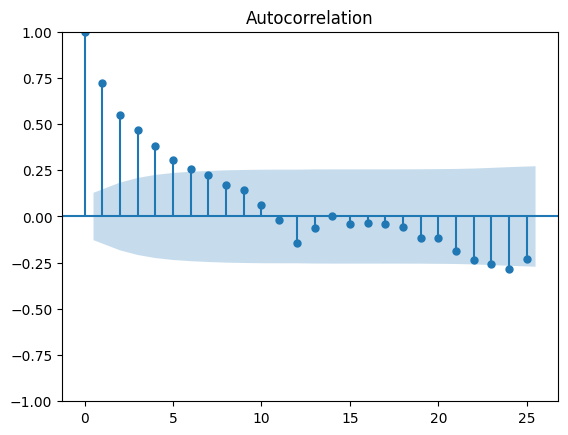

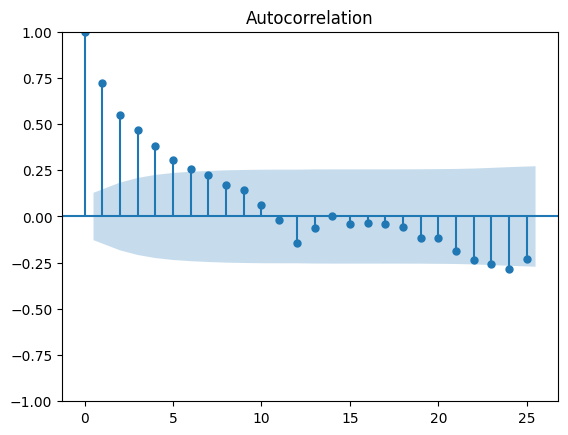

In [185]:
print(type(serie_diff12))
plot_acf(serie_diff12, lags=25)

Las pruebas de autocorrelación interpretan que tanto se correlaciona la variable con cada uno de sus lags. Si están fuera del intervalo azul, significa que con significancia significativa la variable está autocorrelacionada.
En este caso encontramos que
*   **El lag 1,2,3,4,5 y 6 muestran alta autocorrelación.**
*   Tienen

No obstante el modelo AR explica estos valores con su memoria a largo plazo. Por este motivo hay que aplicar la prueba de autocorrelación parcial para no agregar variables que indirectamente están explicadas.

### Autocorrelación parcial PAC


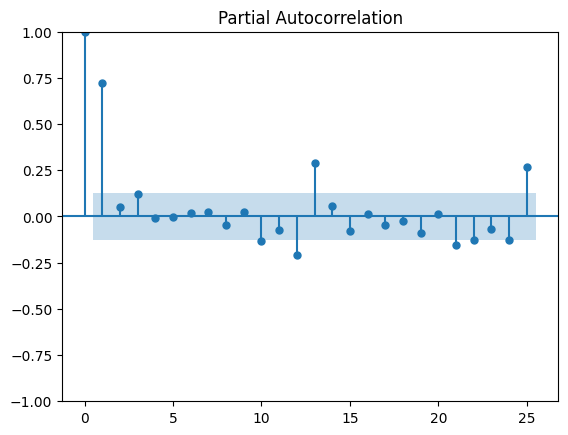

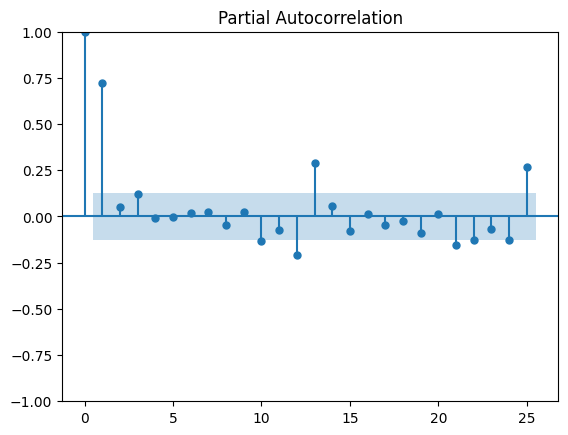

In [186]:
plot_pacf(serie_diff12, lags=25)

Como sospechabamos anteriormente, no es necesario añadir la autocorrelación con los 6 meses anteriores, la prueba de autocorrelación parcial demuestra que el mes anterior explica estas diferencias. Además notamos que el lag 12 y 13 tambien muestran alta correlación. En este caso solo tomaremos en cuenta el mes anterior y el año anterior. Si el lag 1 y el 12 tienen gran significancia es de esperar que el 13 tambien sea dignificativo. Con esta teoría también obesrvamos que el 25 es significativo.

#### Interpretación de las autocorrelaciones:
Para esta serie concluimos que
El lag 1 de la serie tiene una correlación positiva sigificativa del 0.75 y el lag 12 tiene una correlación negativa significativa de alrededor del 0.2 lo que quiere decir que

1.  **El crecimiento porcentual anual del indice de actividad industrial en Querétaro depende en gran medida del valor del mes anterior. En promedio la correlación que existe crecimiento porcentual anual con el mes anterior es de casi el 0.75. Esto quiere decir, que si es grande el crecimiento en un mes, es muy probable que al próximo tambien lo sea.**
2.   **El crecimiento anual porcentual del indice de actividad industrial de Querétaro es propenso a crecer menos sí el año anterior creció mucho."**





## Calibración del modelo ARIMA SARIMA

In [187]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

**p=1 de acuerdo a la prueba pacf solo es necesario el mes anterior para explicar la autocorrelación a largo plazo**

No vamos a utilizar la primera diferencia mensual. Vamons a optar por la estacionaria es decir nuestro modelo tendrá-
*d=1 y D=1*
Pues ya comprobamos que d=1 ó D=1 sí atienden a una serie estaiconaria.

En cuanto a cúantos terminos en el pasado tomamos en cuenta para la nueva predicción, la gráfica de PACF sugiere que el dia anterior tiene un casi un 0.75 de correlación con el valor del día siguiente. Por otra parte el año anterior tienen casi -0.25 de correlación con el valor predecir. Ambos con significancia estadistica por lo que vamos a calibrar el modelo.

*p=1 y P=0*. Tomaremos un termino explicativo del mes anterior.

Finalmente vamos a tomar q y Q como 0. Más adelante aplicaremos la autocorrelación de los residuos y de ser necesario aumentamos estos parametros para explicar la serie con usando los errores anteriores.


Glosario de los terminos para calibrar un modelo ARIMA-SARIMA
p: # of AR terms to be included as explanatory variables

d: # of first differences applied to the original variable

q: # of MA terms to be included as explanatory variables

P: # of Seasonal AR terms to be included as explanatory variables

D: # of Seasonal difference applied to the variable

Q: # of Seasonal MA terms to be included as explanatory variables

In [188]:
model = SARIMAX(df['ln'], order=(1, 1, 0), seasonal_order=(1, 1, 0, 12), trend='c')  # Example order, adjust as needed
sarima_result = model.fit()

##Interpretación de nuestro modelo


In [189]:
print(sarima_result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                 ln   No. Observations:                  246
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                 333.766
Date:                            Sat, 21 Oct 2023   AIC                           -659.533
Time:                                    02:34:45   BIC                           -645.729
Sample:                                         0   HQIC                          -653.966
                                            - 246                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -3.448e-06      0.004     -0.001      0.999      -0.008       0.008
ar.L1         -0.1906      0.060   

De acuerdo a la calibración tenemos un modelo de predicción de la forma
Donde tenemos 1 termino de AR y 1 termino de AR(seasonal)
**y(t)= phi0+ phi1 * y(t-1) + phi12 * y(t-12) + error(t)**



Intercept: Tambien conocido como drift, es el único termino qu eno tiene significancia estadistica, es casi 0. Lo que significa que cuando los otros coeficientes son 0, el valor del iaiqro es cero con poca certeza.

A partir de este modelo los demás coeficiente tienen un p value menor que 0.05,Esto quiere decir que son estadistiamente significativos. Además ninguno de ellos contiene el 0 en su intervalo de confianza 95% a continución veamos su interpretación.


ARL1: Es el phi1. Cuando el crecimiento anual es positivo, el crecimiento anual del índice de actividad industrial del mes actual disminuye en 0.19

ARL12: Es el phi12 correspodiente al termino estacional. Cuando el crecimiento anual del mismo mes en el año anterior es positivo, el crecimiento anual del índice de actividad industrial del mes actual disminuye en 0.37

Sigma2: El sigma muestra error que no puede explicar el modelo es mayor que 0.






###Explicando los errores

In [190]:
# Get the residuals
residuals = sarima_result.resid.iloc[1:]

# Print the residuals
print(residuals)

1     -0.007446
2     -0.052396
3      0.055525
4     -0.087311
5     -0.004195
         ...   
241   -0.028643
242    0.030389
243   -0.060561
244    0.054293
245   -0.002804
Length: 245, dtype: float64


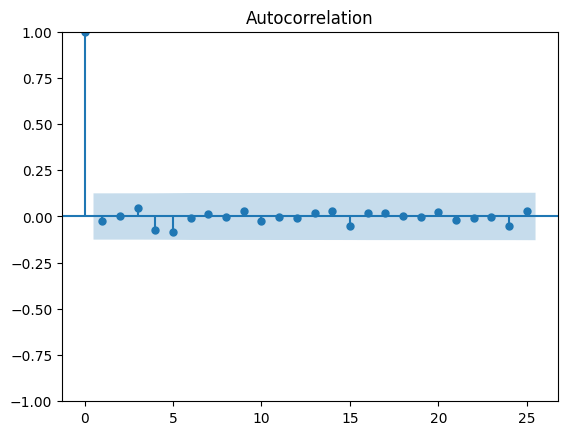

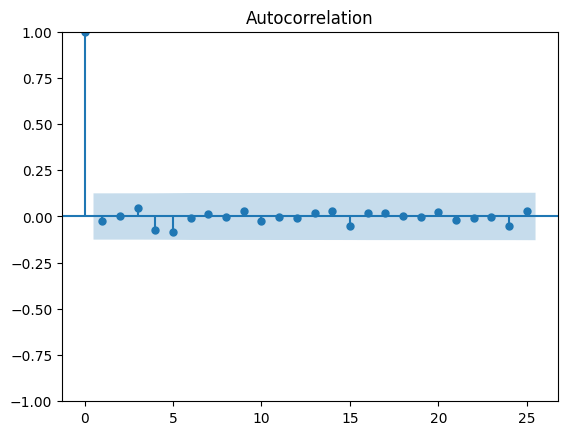

In [191]:
plot_acf(residuals, lags=25)

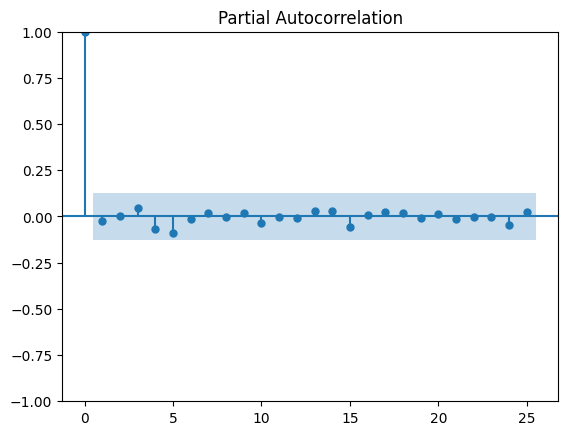

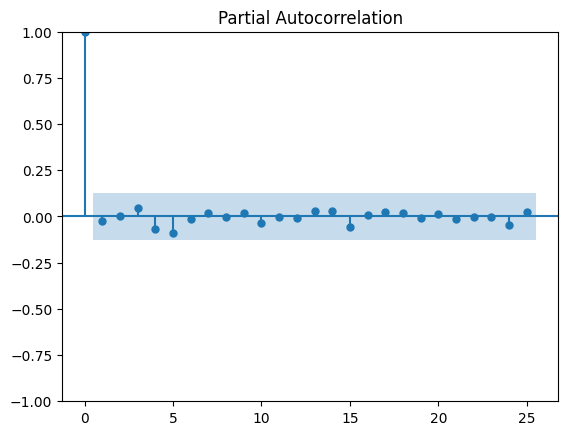

In [192]:
plot_pacf(residuals, lags=25)

#### Ajustes a parametros q y Q

Ahora que comprobamos que no existe una correlación , ni alta ni significativa del crecimiento anual porcentual del indice de actividad industrial en querétaro en un dato mensual respecto a los residuos de  últimos 25 meses podemos afirmar que la calibración del modelo ARIMA SARIMA es adecuada.

#Predicción hacia el 2030


In [193]:
forecast_values = sarima_result.forecast(steps=78)  # Son 78 meses entre junio del 2023 y Enero del 2030
forecast_values = np.exp(forecast_values) #Removemos el logaritmo
print(type(forecast_values))

<class 'pandas.core.series.Series'>


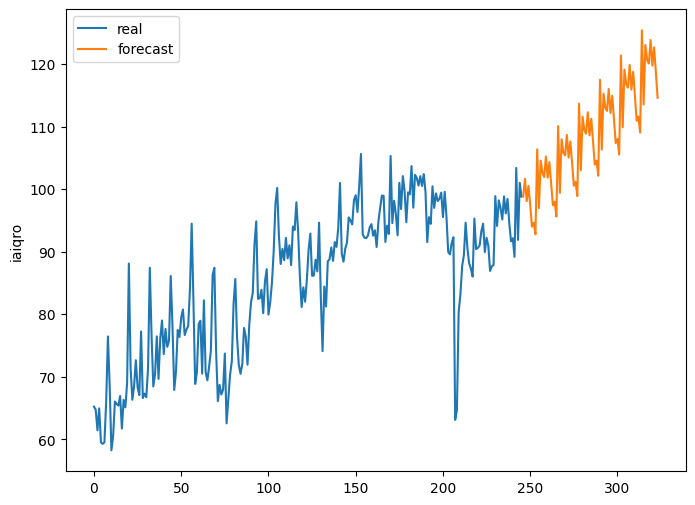

In [194]:
plt.figure(figsize=(8, 6))
sns.lineplot(x=df.index, y='iaiqro', data=df, label='real')
sns.lineplot(forecast_values, label='forecast')
plt.show()

Podemos ver cómo el modelo nos permite predecir que el indice va a la alza.

# Añadiendo una variable externa para explicar la pandemia

In [195]:
#Marzo del 2020
print(df["Periodos"].iloc[206])
df['isCovid'] = 0
df.loc[206:223, 'isCovid'] = 1

2020/03


La variable dummie la establecemos desde Marzo del 2020 y los siguientes 18 meses

                                     SARIMAX Results                                      
Dep. Variable:                                 ln   No. Observations:                  246
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                 334.935
Date:                            Sat, 21 Oct 2023   AIC                           -659.869
Time:                                    02:34:48   BIC                           -642.614
Sample:                                         0   HQIC                          -652.911
                                            - 246                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0001      0.004     -0.028      0.978      -0.008       0.007
isCovid       -0.0522      0.027   

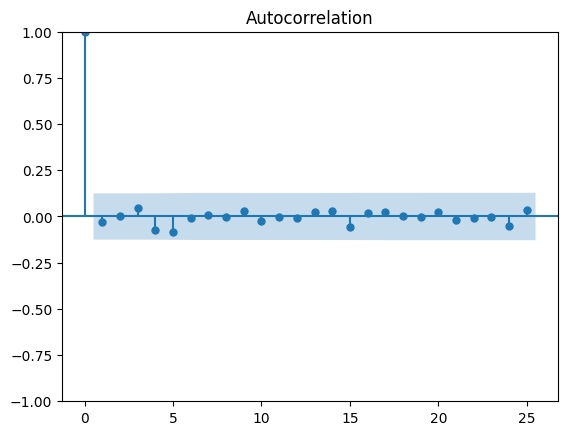

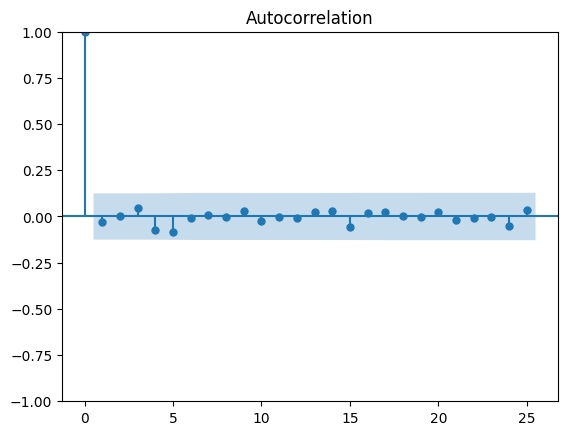

In [196]:
model = SARIMAX(df['ln'], order=(1, 1, 0), seasonal_order=(1, 1, 0, 12), trend='c', exog=df['isCovid'])  # Example order, adjust as needed

model_covid_result = model.fit()
print(model_covid_result.summary())
# Get the residuals
residuals = model_covid_result.resid.iloc[1:]
# Print the residuals
print(residuals)
plot_acf(residuals, lags=25)


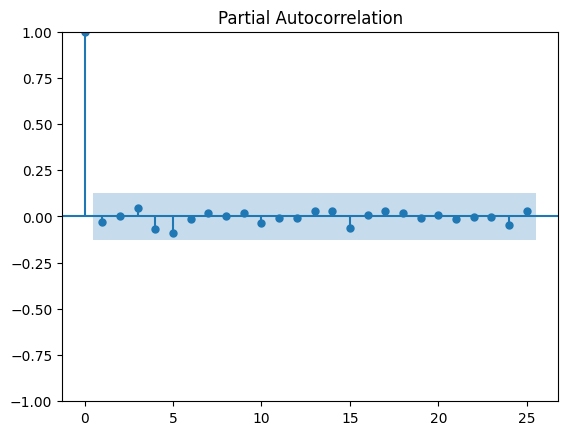

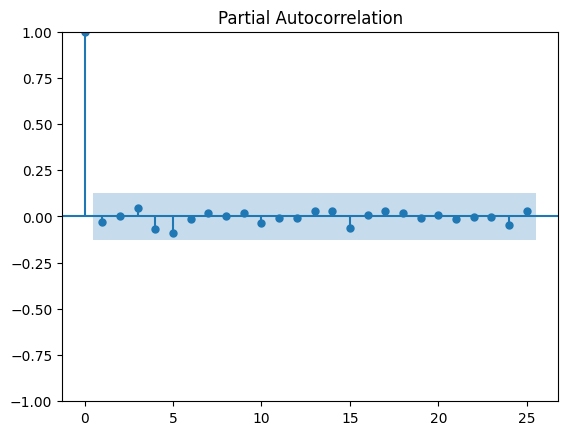

In [197]:
plot_pacf(residuals, lags=25)

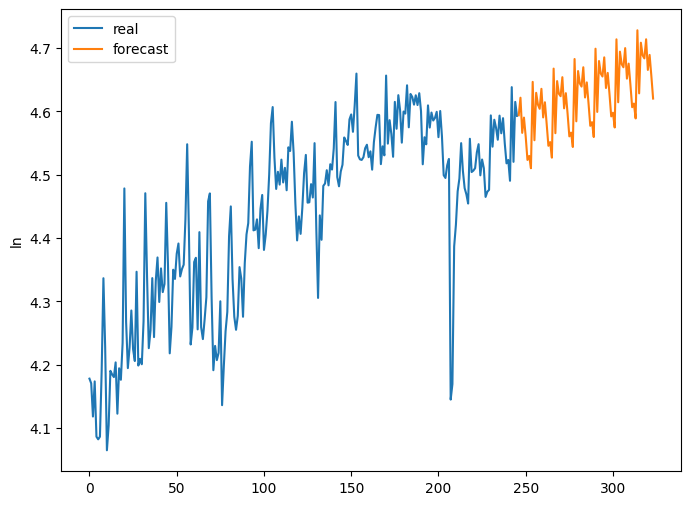

In [198]:
covid_forecast = pd.DataFrame(0, index=range(78), columns=['isCovid'])
forecast_values = model_covid_result.forecast(steps=78,exog=covid_forecast)  # Specify the number of steps to forecast
plt.figure(figsize=(8, 6))
sns.lineplot(x=df.index, y='ln', data=df, label='real')
sns.lineplot(forecast_values, label='forecast')
plt.show()